
---
# Project Introduction

My intention in this project is to explore the data available on [Crunchbase.com](https://www.crunchbase.com), a famous enterprise data website for reporting metrics on companies including startups globally. The website releases its own rankings known as CB Rank (crunchbase rank). 

<p style="text-align:center;"><img src="https://lever-client-logos.s3.amazonaws.com/e055c3e6-3498-44fe-b063-15983d1774aa-1473698174291.png" alt="Flying Kites" width="350" height="90"></p>

The Crunchbase Rank algorithm takes many signals into account including the number of connections a profile has, the level of community engagement, funding events, news articles, and acquisitions.

A company’s Rank is fluid and subject to rising and decaying over time with time-sensitive events. Events such as product launches, funding events, leadership changes, and news affect a company’s Crunchbase Rank. Crunchbase Rank is determined by an algorithm that takes into account the number of connections of a profile within the platform, the amount of community engagement, funding events, news articles, acquisitions, and more. These factors decay over time at varying rates depending on the factor (i.e., news decays more quickly than size of funding rounds). 

In this analysis I am trying to identify any possible relatonship between the nature of the company ie either Tech or Non -Tech and its relationship with the CB Rank of the company, its patents, trademarks, articles, total number of investors, its active tech count or overall trend score. While Rank shows context, Crunchbase Trend Score demonstrates activity. A company’s rank will change based on activity (fundraising, news, etc.) and Trend Score is an indicator of how much their rank is changing at any given time.
**In other words I will use the power of Machine Learning (ML) to predict the nature of a company(ie if it is Tech company or a Non-Tech copmpany) based on available information on these data points.**


---




In [ ]:
# Importing Libraries for the Project
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import warnings
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Data Acquisition
The data used for this project was obtained by me in the month of April 2021 from Crunchbase.com and includes the top 10000 companies listed by crunchbase based on its metric CB rank (or Crunch base rank). In addition to ranks other data points include **Organization Name,	Number of Published Articles,	Founded Date,	Company Type (Profit or Non-Profit),Industry Groups, Number of Investors,	Patents Granted,	Trademarks Registered,	Active Tech Count (total active technologies being used by the company),	Trend Score** (90 Days) *i.e how an entity is trending in the Crunchbase ecosystem based on its movement in rank relative to all the other entities in its entity type for last 90 days*

I used their data portal to access and download this data using the export to csv feature. I selected these datapoints mannually among many others as these were relevent to my study. Since crunchbase has limited access to its data for free users I downloaded them in clusters of 1000 each and then merged them into one single sheet using pandas library in a seperate python script. The data is ranked according to the CB Rank of each organization and is hosted on my GitHub account.

The Crunchbase Rank algorithm takes many signals into account including the number of connections a profile has, the level of community engagement, funding events, news articles, and acquisitions. The Crunchbase rank uses Crunchbase’s intelligent algorithms to score and rank entities (e.g. Company, People, Investors, etc.) so you can quickly see what matters most in real time. The algorithms take into account many different variables, ranging from Total Funding Amount, that entity’s strength of relationships with other entities in the Crunchbase ecosystem, and how many times the entity has been viewed recently.

A company’s Rank is fluid and subject to rising and decaying over time with time-sensitive events. Events such as product launches, funding events, leadership changes, and news affect a company’s Crunchbase Rank. <br>(Source: *https://about.crunchbase.com/blog/crunchbase-rank-trend-score/)*

In [ ]:
def install_data():
  original_df = pd.read_csv("https://raw.githubusercontent.com/mihakim2/DMAP490/main/CrunchBase_3000%20-%20Orig.csv")
  df = pd.read_csv("https://raw.githubusercontent.com/mihakim2/DMAP490/main/cbdata.csv")
  #make column names simpler
  df.columns = df.columns.str.replace(' ', '')
  df = df.replace(',','', regex=True)
  df['CBRank'] = pd.to_numeric(df['CBRank'])
  df['NumberofArticles'] = pd.to_numeric(df['NumberofArticles'])
  df['PatentsGranted'] = pd.to_numeric(df['PatentsGranted'])
  df['TrademarksRegistered'] = pd.to_numeric(df['TrademarksRegistered'])
  return df
df = install_data()
df

,OrganizationName,Industries,HeadquartersLocation,CBRank,NumberofArticles,CompanyType,NumberofInvestors,PatentsGranted,TrademarksRegistered,ActiveTechCount,TrendScore
0,SoftBank,Banking,Tokyo Tokyo Japan,1,8068.0,For Profit,1.0,246.0,68.0,94.0,1.2
1,Compass,Marketplace,New York New York United States,2,219.0,For Profit,32.0,0.0,7.0,87.0,5.1
2,Crowdcube,Business Development,Exeter Devon United Kingdom,3,1280.0,For Profit,9.0,0.0,3.0,30.0,-0.4
3,Zoom,Collaboration,San Jose California United States,4,2890.0,For Profit,18.0,8.0,11.0,71.0,2.3
4,Ant Group,Banking,Hangzhou Zhejiang China,5,2351.0,For Profit,15.0,NaN,NaN,13.0,-0.4
...,...,...,...,...,...,...,...,...,...,...,...
9994,LYNK Logistics,Logistics,Mylapore Tamil Nadu India,9996,NaN,For Profit,1.0,NaN,NaN,26.0,-0.7
9995,MyRealTrip,Collaborative Consumption,Seoul Seoul-t'ukpyolsi South Korea,9997,27.0,For Profit,12.0,NaN,NaN,40.0,-0.7
9996,Till,Financial Services,Alexandria Virginia United States,9998,NaN,For Profit,5.0,NaN,NaN,34.0,-0.1
9997,Andpad,Apps,Tokyo Tokyo Japan,9999,1.0,For Profit,8.0,NaN,NaN,48.0,-0.2


# Data Manipulation & Selection
Since this analysis focusses on categorizing companies based on broadly two categories ie as **Tech** or as **Non-Tech**.
This was done by first identyfying unique Industry category in the dataset and then classifying them as 1 or 0 where 1 signifies a business is Tech while 0 is Non Tech. This will be merged with the above dataset to represent industry types and if it is Tech or not.

In [ ]:
df_dic = pd.read_csv("https://raw.githubusercontent.com/mihakim2/DMAP490/main/cb_data_dicitonary.csv")
df_dic

,Industries,Type,Tech
0,Banking,1,0
1,Marketplace,2,1
2,Business Development,3,0
3,Collaboration,4,0
4,Productivity Tools,5,1
...,...,...,...
395,Product Design,396,0
396,Assisted Living,397,0
397,Private Social Networking,398,1
398,Social Media Marketing,399,1


In order to merge the two dataframes, mapping feature of pandas is used alongside Python dictionaries. There are multiple ways to do it. However, I find this to be easiest.

In [ ]:
code_dict = dict(zip(df_dic.Industries, df_dic.Type))
tech_dict=  dict(zip(df_dic.Industries, df_dic.Tech))

#Remap the values of the dataframe
df.loc[:,'Ind_type']=df['Industries']
df.loc[:,'is_tech']=df['Industries']
df["Ind_type"] = df["Ind_type"].map(code_dict)
df["is_tech"] = df["is_tech"].map(tech_dict)
df

,OrganizationName,Industries,HeadquartersLocation,CBRank,NumberofArticles,CompanyType,NumberofInvestors,PatentsGranted,TrademarksRegistered,ActiveTechCount,TrendScore,Ind_type,is_tech
0,SoftBank,Banking,Tokyo Tokyo Japan,1,8068.0,For Profit,1.0,246.0,68.0,94.0,1.2,1.0,0.0
1,Compass,Marketplace,New York New York United States,2,219.0,For Profit,32.0,0.0,7.0,87.0,5.1,2.0,1.0
2,Crowdcube,Business Development,Exeter Devon United Kingdom,3,1280.0,For Profit,9.0,0.0,3.0,30.0,-0.4,3.0,0.0
3,Zoom,Collaboration,San Jose California United States,4,2890.0,For Profit,18.0,8.0,11.0,71.0,2.3,4.0,0.0
4,Ant Group,Banking,Hangzhou Zhejiang China,5,2351.0,For Profit,15.0,NaN,NaN,13.0,-0.4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,LYNK Logistics,Logistics,Mylapore Tamil Nadu India,9996,NaN,For Profit,1.0,NaN,NaN,26.0,-0.7,178.0,0.0
9995,MyRealTrip,Collaborative Consumption,Seoul Seoul-t'ukpyolsi South Korea,9997,27.0,For Profit,12.0,NaN,NaN,40.0,-0.7,143.0,0.0
9996,Till,Financial Services,Alexandria Virginia United States,9998,NaN,For Profit,5.0,NaN,NaN,34.0,-0.1,24.0,0.0
9997,Andpad,Apps,Tokyo Tokyo Japan,9999,1.0,For Profit,8.0,NaN,NaN,48.0,-0.2,23.0,1.0


#Data Cleaning
Let us check our dataset for any missing values, since these donot add any value to the analysis we will drop the rows with missing values or NaN values.

In [ ]:
df.isna().any()

OrganizationName        False
Industries               True
HeadquartersLocation     True
CBRank                  False
NumberofArticles         True
CompanyType              True
NumberofInvestors        True
PatentsGranted           True
TrademarksRegistered     True
ActiveTechCount          True
TrendScore              False
Ind_type                 True
is_tech                  True
dtype: bool

Dropping missing values

In [ ]:
print("Dataset with missing values",df.shape)
df=df.dropna()
print("Missing values dropped....")
print("After dropping missing values",df.shape)

Dataset with missing values (9999, 13)
Missing values dropped....
After dropping missing values (5956, 13)


In [ ]:
df

,OrganizationName,Industries,HeadquartersLocation,CBRank,NumberofArticles,CompanyType,NumberofInvestors,PatentsGranted,TrademarksRegistered,ActiveTechCount,TrendScore,Ind_type,is_tech
0,SoftBank,Banking,Tokyo Tokyo Japan,1,8068.0,For Profit,1.0,246.0,68.0,94.0,1.2,1.0,0.0
1,Compass,Marketplace,New York New York United States,2,219.0,For Profit,32.0,0.0,7.0,87.0,5.1,2.0,1.0
2,Crowdcube,Business Development,Exeter Devon United Kingdom,3,1280.0,For Profit,9.0,0.0,3.0,30.0,-0.4,3.0,0.0
3,Zoom,Collaboration,San Jose California United States,4,2890.0,For Profit,18.0,8.0,11.0,71.0,2.3,4.0,0.0
5,Calendly,Productivity Tools,Atlanta Georgia United States,6,37.0,For Profit,3.0,0.0,2.0,45.0,9.3,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,Caremerge,Elderly,Chicago Illinois United States,9992,27.0,For Profit,8.0,0.0,1.0,71.0,-0.1,363.0,0.0
9991,Zycada,B2B,San Jose California United States,9993,1.0,For Profit,7.0,7.0,0.0,41.0,-0.3,77.0,0.0
9992,Arena Pharmaceuticals,Biotechnology,San Diego California United States,9994,181.0,For Profit,2.0,317.0,31.0,38.0,-4.7,40.0,1.0
9993,Prevalent Networks,Information Services,Warren New Jersey United States,9995,3.0,For Profit,3.0,0.0,2.0,40.0,-0.7,130.0,1.0


**This looks Much Better!**

#Data Visualization
We can see below among that in the dataset Analytics, AI and Biotechnology are among the categories of Industires with most companies listed. 
(Hover over the bar to display category)

In [ ]:
import plotly.express as px
fig = px.bar(df, x=df['Industries'])
fig.show()

Let us also check the distribution of data to prevent any biases in Model. We ould prefer the data to be equaly divided or somewhere closer. in our case the data counts for the two types (Tech or Non-Tech) is close enough and comparable. In this case, furthur normalization is thus not needed.

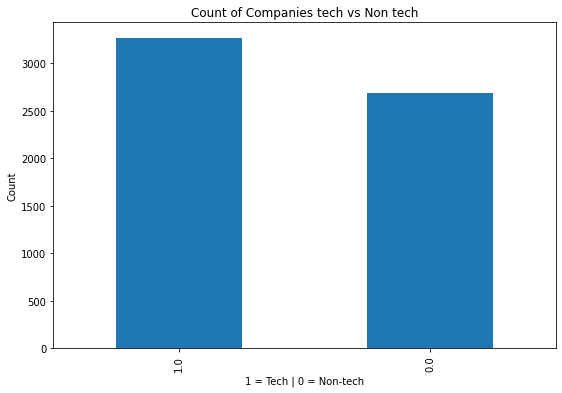

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = df['is_tech'].value_counts().plot(kind='bar',
                                    figsize=(9,6),
                                    title="Count of Companies tech vs Non tech")
ax.set_xlabel("1 = Tech | 0 = Non-tech")
ax.set_ylabel("Count")
plt.show()

Let us now take a look at how well the data correlates with each other and try to visualize it using a heatmap.

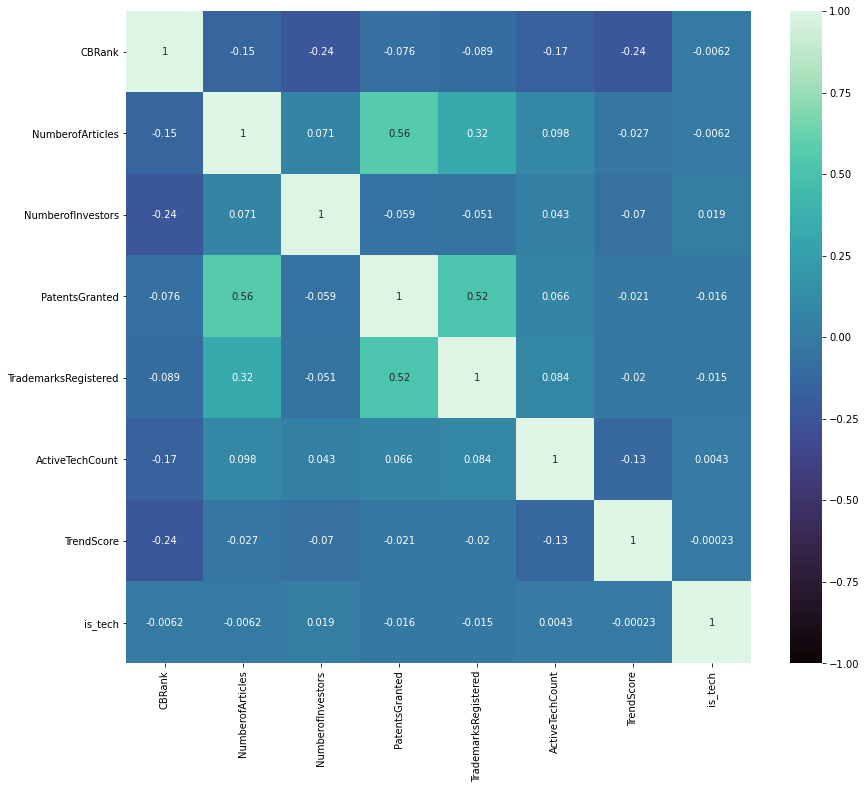

In [ ]:
df2=df
df2 = df2.drop(columns = ['OrganizationName','Industries','HeadquartersLocation','Ind_type'])
plt.figure(figsize = (14,12))
sn.heatmap(df2.corr(),annot=True, vmin=-1.0, cmap='mako')

We can also try and consider visualizing  validity of CB Rank. Below we can not that there is a negative correlation of CB Rank with almost every factor. ie Lower the CB rank - higher the factores (ie No of Article, No of Investors, Patents, Trademarks etc)

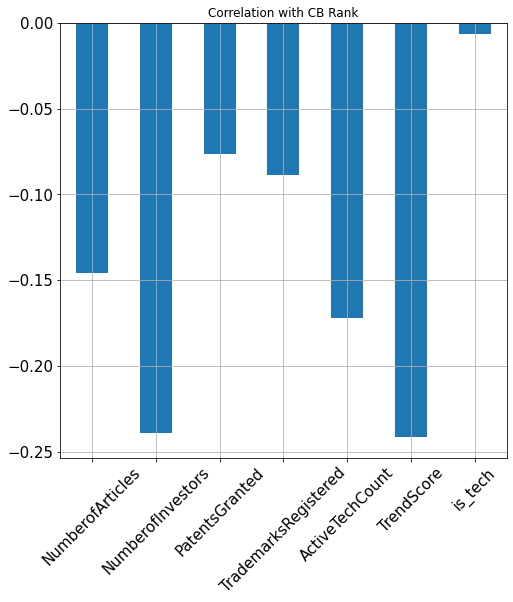

In [ ]:
#CORRELATION WITH CBRANKS
dummy = df2.copy().drop(columns = ['CBRank'])

dummy.corrwith(df2.CBRank).plot.bar(figsize = (8,8),
                                      title = 'Correlation with CB Rank',
                                      fontsize = 15, rot = 45,
                                      grid = True)

In [ ]:
df2

,CBRank,NumberofArticles,CompanyType,NumberofInvestors,PatentsGranted,TrademarksRegistered,ActiveTechCount,TrendScore,is_tech
0,1,8068.0,For Profit,1.0,246.0,68.0,94.0,1.2,0.0
1,2,219.0,For Profit,32.0,0.0,7.0,87.0,5.1,1.0
2,3,1280.0,For Profit,9.0,0.0,3.0,30.0,-0.4,0.0
3,4,2890.0,For Profit,18.0,8.0,11.0,71.0,2.3,0.0
5,6,37.0,For Profit,3.0,0.0,2.0,45.0,9.3,1.0
...,...,...,...,...,...,...,...,...,...
9990,9992,27.0,For Profit,8.0,0.0,1.0,71.0,-0.1,0.0
9991,9993,1.0,For Profit,7.0,7.0,0.0,41.0,-0.3,0.0
9992,9994,181.0,For Profit,2.0,317.0,31.0,38.0,-4.7,1.0
9993,9995,3.0,For Profit,3.0,0.0,2.0,40.0,-0.7,1.0


This is how our cleaned dataset looks so far ;) <br> Now let us try and explore possible relationships or how well do these parametrs explain the designation of these companies as Tech or Non-Tech in the dataframe using ML algorithms we learnt in DMAP. In a way we are asking the computer to mimic the human brain that wa sinvolved in designating these companies as Tech or Non-Tech to develop a model for future designations.

# Data Analysis

In [ ]:
# Define the x and y axis
df_clean=df2
y = df_clean.is_tech
cols = ["CBRank","NumberofArticles","NumberofInvestors","PatentsGranted","TrademarksRegistered","ActiveTechCount","TrendScore"] 
x=df_clean[cols]
x

,CBRank,NumberofArticles,NumberofInvestors,PatentsGranted,TrademarksRegistered,ActiveTechCount,TrendScore
0,1,8068.0,1.0,246.0,68.0,94.0,1.2
1,2,219.0,32.0,0.0,7.0,87.0,5.1
2,3,1280.0,9.0,0.0,3.0,30.0,-0.4
3,4,2890.0,18.0,8.0,11.0,71.0,2.3
5,6,37.0,3.0,0.0,2.0,45.0,9.3
...,...,...,...,...,...,...,...
9990,9992,27.0,8.0,0.0,1.0,71.0,-0.1
9991,9993,1.0,7.0,7.0,0.0,41.0,-0.3
9992,9994,181.0,2.0,317.0,31.0,38.0,-4.7
9993,9995,3.0,3.0,0.0,2.0,40.0,-0.7


In order to split the data into testing and training sets, I used the TraintestSplit method of scikit learn. Split arrays or matrices into random train and test subsets
It is a quick utility that wraps input validation and and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.

In [ ]:
warnings.filterwarnings("ignore")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Running ML Processes
In this analysis seven algorithms would be tested for performance with dataset.
These are-


*   [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
*   [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree)
*   [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
*   [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
*   [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine)
*   [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
*   [XGboost](https://en.wikipedia.org/wiki/XGBoost)









In [ ]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr = logreg.predict(X_test)
y_valid=logreg.predict(X_train)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, lr))
print("\n")

# check classification scores of DecisionTreeClassifier
dtmodel = tree.DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt = dtmodel.predict(X_test)
print('Train/Test split results:')
print(dtmodel.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, dt))
print("\n")

# check classification scores of RandomForestClassifier
rfmodel = RandomForestClassifier(max_depth = 8, random_state = 42)
rfmodel.fit(X_train, y_train)
rf = rfmodel.predict(X_test)
print('Train/Test split results:')
print(rfmodel.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, rf))
print("\n")

# check classification scores of KNeighborsClassifier
knnmodel=KNeighborsClassifier(n_neighbors=3) #this examines 3 neighbours for putting the new data into a class
knnmodel.fit(X_train, y_train)
knn = knnmodel.predict(X_test)
print('Train/Test split results:')
print(knnmodel.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, knn))
print("\n")

# check classification scores of SVM
from sklearn import svm
svmmodel=svm.SVC()
svmmodel.fit(X_train, y_train)
svm= svmmodel.predict(X_test)
print('Train/Test split results:')
print("SVM accuracy is %2.3f" % accuracy_score(y_test, svm))
print("\n")

#Gradient boosting classifier
gbmodel = GradientBoostingClassifier(random_state = 0)
gbmodel.fit(X_train, y_train)
gbr = gbmodel.predict(X_test)
print('Train/Test split results:')
print(gbmodel.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, gbr))
print("\n")

#XGBoost
import xgboost as xgb
xgbmodel = xgb.XGBRegressor(objective = 'reg:logistic', random_state = 42)
xgbmodel.fit(X_train, y_train)
xgb = xgbmodel.predict(X_test)
for i in range(len(xgb)):
  if xgb[i] >= 0.5:
    xgb[i]=1
  else:
    xgb[i]=0
print('Train/Test split results:')
print(xgbmodel.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, xgb))

Train/Test split results:
LogisticRegression accuracy is 0.534


Train/Test split results:
DecisionTreeClassifier accuracy is 0.507


Train/Test split results:
RandomForestClassifier accuracy is 0.552


Train/Test split results:
KNeighborsClassifier accuracy is 0.515


Train/Test split results:
SVM accuracy is 0.535


Train/Test split results:
GradientBoostingClassifier accuracy is 0.544


Train/Test split results:
XGBRegressor accuracy is 0.541


Let us organize the results and use metrics to compare the algorithms in a table.

In [ ]:
# results for Logistic regression

ac = accuracy_score(y_test, lr)
f1 = f1_score(y_test, lr)
ps = precision_score(y_test, lr)
rs = recall_score(y_test, lr)

results = pd.DataFrame([['Logistic regression', ac, f1, ps, rs ]], columns = ['Model', 'Accuracy', 'F1 score', 'Precision', 'Recall score'])
results

,Model,Accuracy,F1 score,Precision,Recall score
0,Logistic regression,0.533557,0.695509,0.533165,1.0


In [ ]:
models = [dt, rf, knn,svm, gbr, xgb]
model_names = ['Decision tree', 'Random forest', 'K-NearestNeighbours','SVM', 'Gradient boost', 'XG boost']
index = 0

for model in models:
    ac = accuracy_score(y_test, model)
    f1 = f1_score(y_test, model)
    ps = precision_score(y_test, model)
    rs = recall_score(y_test, model)
    temp_results = pd.DataFrame([[model_names[index], ac, f1, ps, rs]], columns = ['Model', 'Accuracy', 'F1 score', 'Precision', 'Recall score'])
    results = results.append(temp_results, ignore_index = True)
    index = index + 1
results

,Model,Accuracy,F1 score,Precision,Recall score
0,Logistic regression,0.533557,0.695509,0.533165,1.000000
1,Decision tree,0.506711,0.532591,0.537721,0.527559
2,Random forest,0.552013,0.677146,0.549558,0.881890
3,K-NearestNeighbours,0.515101,0.568012,0.540541,0.598425
4,SVM,0.535235,0.695604,0.534177,0.996850
5,Gradient boost,0.543624,0.657862,0.547644,0.823622
6,XG boost,0.541107,0.650925,0.547210,0.803150


We can see above that the Accuracy in almost every algorithm is almost same, however in case of Random Forest the Accuracy is highest at 55.2% followed by XGboost at 54.3%

# Interactive Plot for displaying Results and Confusion matrix

In [ ]:
lrcm = confusion_matrix(y_test, lr)
dtcm = confusion_matrix(y_test, dt)
rfcm = confusion_matrix(y_test, rf)
svmcm = confusion_matrix(y_test, svm)
gbcm = confusion_matrix(y_test, gbr)
xgbcm = confusion_matrix(y_test, xgb)
knncm= confusion_matrix(y_test, knn)

def f(Model='Random forest'):
    if Model == 'Logistic regression':
      cl=lrcm
    elif Model == 'Decision tree':
      cl=dtcm
    elif Model == 'Random forest':
      cl=rfcm
    elif Model == 'K-NearestNeighbours':
      cl=knncm
    elif Model == 'SVM':
      cl=svmcm
    elif Model == 'Gradient boost':
      cl=gbcm
    elif Model == 'XGBoost':
      cl=xgbcm
      
    %matplotlib inline
    row = 0
    df_cm = pd.DataFrame(cl, index = (0,1), columns = (0,1))
    plt.figure(figsize = (6,4))
    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot = True, fmt = 'g')
    plt.title(Model)
    row = row+1
    display(results.loc[results['Model'] == Model])
print("Please select a Model from the dropdown below")
interactive_plot = interactive(f, Model=['Logistic regression', 'Decision tree', 'Random forest','K-NearestNeighbours', 'SVM', 'Gradient boost', 'XGBoost'])
output = interactive_plot.children[-1]

interactive_plot

Please select a Model from the dropdown below


interactive(children=(Dropdown(description='Model', index=2, options=('Logistic regression', 'Decision tree', …

# Conclusion
Although the accuracy of the models is not great but this exercise helped to understand implementation of ML algorithms on any datasets. We can use this analysis to make simple models for our day to day research project to identify trends and patterns in datasets.

In [ ]:
results

,Model,Accuracy,F1 score,Precision,Recall score
0,Logistic regression,0.533557,0.695509,0.533165,1.000000
1,Decision tree,0.506711,0.532591,0.537721,0.527559
2,Random forest,0.552013,0.677146,0.549558,0.881890
3,K-NearestNeighbours,0.515101,0.568012,0.540541,0.598425
4,SVM,0.535235,0.695604,0.534177,0.996850
5,Gradient boost,0.543624,0.657862,0.547644,0.823622
6,XG boost,0.541107,0.650925,0.547210,0.803150


**Accuracy**
Accuracy is the basic metric to evaluate classification models and measures the percentage of correctly predicted data against the total data. This is a metric that is best used for a balanced data set. In order to find out the accuracy, we should have a confusion matrix.

**Precision**
Precision is a metric that quantifies the number of correct positive predictions made. This is a metric that can be used for an unbalanced data set. In essence, It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted

**Recall / Sensitivity**
Recall is calculated as the number of true positives divided by the total number of true positives and false negatives. This is a metric that can be used for an unbalanced data set.

**F1 Score**
F1 Score measure provides a way to combine both precision and recall into a single measure that captures both properties.
As mentioned before, precision is a metric to minimize false positive rate (model too ‘confident’ labels data as ‘positive’). On the other hand, recall is a metric to minimize false positive rate (the model fails to detect data that is actually ‘positive’).

#Predictions
Let us use our model to make predictions and make a simple application to predict if a company is Tech company or Not!

In [ ]:
tech_bol= (svmmodel.predict([[15,4346,45,35,23,12,2]]))
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
if tech_bol==1:
  print(color.BOLD + "The company is probabaly a Tech Company!" + color.END)
elif tech_bol==0:
  print(color.BOLD+ "The company is probabaly NOT a Tech Company!"+ color.END)

The company is probabaly a Tech Company!


In [ ]:
cbrank = input('Enter the CB-Rank: ')
articles = input('Enter the NumberofArticles: ')
investors = input('Enter the Number of Investors: ')
patents = input('Enter the No of Patents: ')
trademarks = input('Enter the No of TrademarksRegistered: ')
activetech = input('Enter the ActiveTechCount: ')
trend = input('Enter the TrendScore: ')
tech_bol= (svmmodel.predict([[cbrank,articles,investors,patents,trademarks,activetech,trend]]))
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
if tech_bol==1:
  print(color.BOLD + "The company is probabaly a Tech Company!" + color.END)
elif tech_bol==0:
  print(color.BOLD+ "The company is probabaly NOT a Tech Company!"+ color.END)
else:
  print("oops!Something wrong happend, give it another try!")

Enter the CB-Rank: 45
Enter the NumberofArticles: 45
Enter the Number of Investors: 3534
Enter the No of Patents: 3535
Enter the No of TrademarksRegistered: 5345
Enter the ActiveTechCount: 45
Enter the TrendScore: 45
The company is probabaly a Tech Company!
